## Visualization Tool

In [ ]:
from graphviz import Digraph
import random
import math
from math import exp

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n.operator:
            dot.node(name=str(id(n)) + n.operator, label=n.operator)
            dot.edge(str(id(n)) + n.operator, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

## Tensor

In [ ]:
class Tensor:

  def __init__(self, value, label='', children=(), operator=None):
    self.value = value
    self.children = set(children)
    self.operator = operator
    self.grad = 0
    self._backward = lambda  : None
    self.label = label


  def __repr__(self) -> str:
    return f"Tensor(label = {self.label}, value = {self.value}, grad = {self.grad}, operator = {self.operator})"


  def __add__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value + other.value
    out = Tensor(out_value, children=(self, other), operator='+')

    def backward():
      self.grad = 1 * out.grad
      other.grad = 1 * out.grad

    out._backward = backward

    return out

  def __radd__(self, other):
    return self + other


  def __sub__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value - other.value
    out = Tensor(out_value, children=(self, other), operator='-')

    def backward():
      self.grad = 1 * out.grad
      other.grad = -1 * out.grad

    out._backward = backward

    return out


  def __mul__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out_value = self.value * other.value
    out = Tensor(out_value, children= (self, other), operator='*')

    def backward():
      self.grad = other.value * out.grad
      other.grad = self.value * out.grad

    out._backward = backward

    return out

  def __rmul__(self, other):
    return self * other


  def __truediv__(self, other):

      other = other if isinstance(other, Tensor) else Tensor(other)

      out_value = self.value / other.value
      out = Tensor(out_value, children= (self, other), operator='/')

      def backward():
        self.grad = (1 / other.value) * out.grad
        other.grad = (-self.value / (other.value ** 2)) * out.grad

      out._backward = backward

      return out


  def __pow__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value ** other.value
    out = Tensor(out_value, children= (self, ), operator='**')

    def backward():
      self.grad = other.value * self.value ** (other.value - 1) * out.grad

    out._backward = backward

    return out


  def backward(self):
    topo_sort = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.children:
          build_topo(child)
        topo_sort.append(v)

    build_topo(self)
    self.grad = 1
    for node in reversed(topo_sort):
      node._backward()

# Activation Functions

In [ ]:
class F:

  @staticmethod
  def tanh(x: Tensor) -> Tensor:

    input_value = x.value
    output_value = (exp(input_value) - exp(-input_value)) / (exp(input_value) + exp(-input_value))

    out = Tensor(output_value, children=(x, ), operator='tanh')

    def backward():
      x.grad = (1 - output_value ** 2) * out.grad

    out._backward = backward

    return out

  def sigmoid(x):
    input_value = x.value
    input_value = -1.0 * input_value
    output_value = 1.0/(1.0 + exp(input_value))

    out = Tensor(output_value, children=(x, ), operator='sigm')

    def backward():
      x.grad = output_value * (1 - output_value) * out.grad

    out._backward = backward

    return out

# Neuron, Layer & MLP (Forward Section)

In [ ]:
class Neuron:

  def __init__(self, input_size):

    self.weights = [Tensor(random.uniform(-1, 1)) for i in range(input_size)]
    self.bias = Tensor(random.uniform(-1, 1))

  def forward(self, x):
    res = sum([w_i * x_i for w_i, x_i in zip(self.weights, x)])
    return F.tanh(res + self.bias)

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return self.weights

  def __print__(self):
    return self.parameters()

In [ ]:
class Layer:

  def __init__(self, input_size, output_size):
    self.neurons = [Neuron(input_size) for _ in range(output_size)]

  def forward(self, x):
    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    neuron_list = []
    for neuron in self.neurons:
      neuron_list.append(neuron.parameters())

    return neuron_list

  def __print__(self):
    return self.parameters()

In [ ]:
class MLP:

  def __init__(self, input_size, layer_sizes):
    layers_total = [input_size] + layer_sizes
    self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    layer_list = []
    for layer in self.layers:
      layer_list.append(layer.parameters())

    return layer_list

  def __print__(self):
    return self.parameters()

# Optimizer

In [ ]:
class Optimizer:
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr

  def zero_grad(self):
    for layer in self.parameters:
      for neuron in layer:
        for weight_and_bias in neuron:
          weight_and_bias.grad = 0

  def step(self):
    for layer in self.parameters:
      for neuron in layer:
        for weight_and_bias in neuron:
          weight_and_bias.value -= self.lr * weight_and_bias.grad

# Training Part

In [ ]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

Y = [1.0, -1.0, -1.0, 1.0]

## Loss Function (SSE)

In [ ]:
from typing import List

def criterion(y_hats: List[Tensor], Y) -> Tensor:
  return sum([(y_hat - y)**2 for y_hat, y in zip(y_hats, Y)])

## Training Loop

iteration: 0, loss: Tensor(label = , value = 3.6699647226223338, grad = 0, operator = +)
iteration: 1, loss: Tensor(label = , value = 3.161565938156889, grad = 0, operator = +)
iteration: 2, loss: Tensor(label = , value = 0.831465411422905, grad = 0, operator = +)
iteration: 3, loss: Tensor(label = , value = 0.20914482343913077, grad = 0, operator = +)
iteration: 4, loss: Tensor(label = , value = 0.18047122847913064, grad = 0, operator = +)
iteration: 5, loss: Tensor(label = , value = 0.13539463958130366, grad = 0, operator = +)
iteration: 6, loss: Tensor(label = , value = 0.12561498345984798, grad = 0, operator = +)
iteration: 7, loss: Tensor(label = , value = 0.11807096481525084, grad = 0, operator = +)
iteration: 8, loss: Tensor(label = , value = 0.09632908863147784, grad = 0, operator = +)
iteration: 9, loss: Tensor(label = , value = 0.08249957694908465, grad = 0, operator = +)
iteration: 10, loss: Tensor(label = , value = 0.07243861713743116, grad = 0, operator = +)
iteration: 11,

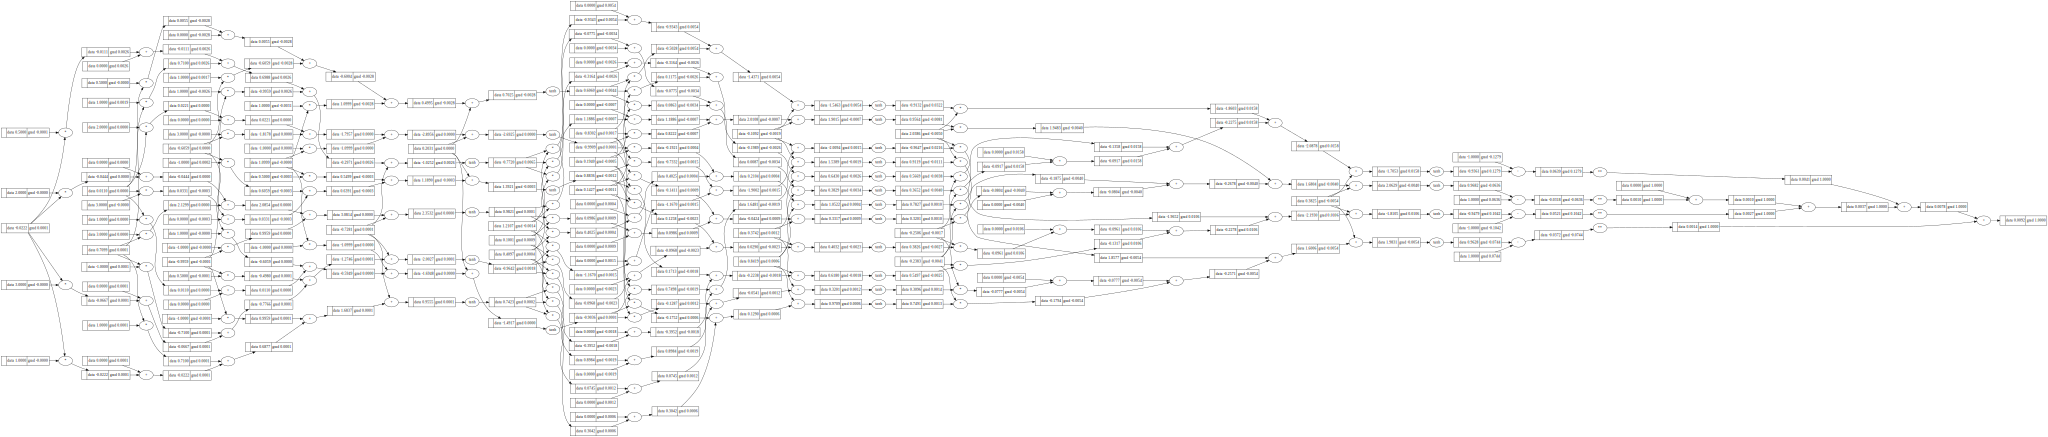

In [ ]:
n_epochs = 100

input_size = 3 # Number of features in the input layer
layer_sizes = [2, 3, 1] # Number of neurons in each hidden and output layer
model = MLP(input_size, layer_sizes)

optim = Optimizer(model.parameters(), lr=0.3)

for i in range(n_epochs):
  # Forward pass: Compute predictions for the entire dataset
  y_hats = [model(x) for x in X]

  # Compute the loss
  loss = criterion(y_hats, Y)
  print(f'iteration: {i}, loss: {loss}')

  # Zero the gradients to prevent accumulation from previous iterations
  optim.zero_grad()

  # Backward pass: Compute the gradient of the loss function with respect to model parameters
  loss.backward()
  # print(f'iteration: {i}, loss: {loss}')

  # Update the model parameters using the optimizer
  optim.step()

draw_dot(loss)

iteration: 0, loss: Tensor(label = , value = 7.591733177323704, grad = 0, operator = +)
iteration: 1, loss: Tensor(label = , value = 7.580263365176451, grad = 0, operator = +)
iteration: 2, loss: Tensor(label = , value = 7.562363764112409, grad = 0, operator = +)
iteration: 3, loss: Tensor(label = , value = 7.530586526966641, grad = 0, operator = +)
iteration: 4, loss: Tensor(label = , value = 7.515956878001107, grad = 0, operator = +)
iteration: 5, loss: Tensor(label = , value = 7.501317606113513, grad = 0, operator = +)
iteration: 6, loss: Tensor(label = , value = 7.488911093693927, grad = 0, operator = +)
iteration: 7, loss: Tensor(label = , value = 7.477434553935158, grad = 0, operator = +)
iteration: 8, loss: Tensor(label = , value = 7.4544719235797565, grad = 0, operator = +)
iteration: 9, loss: Tensor(label = , value = 7.443959392877222, grad = 0, operator = +)
iteration: 10, loss: Tensor(label = , value = 7.434659170347366, grad = 0, operator = +)
iteration: 11, loss: Tensor(la

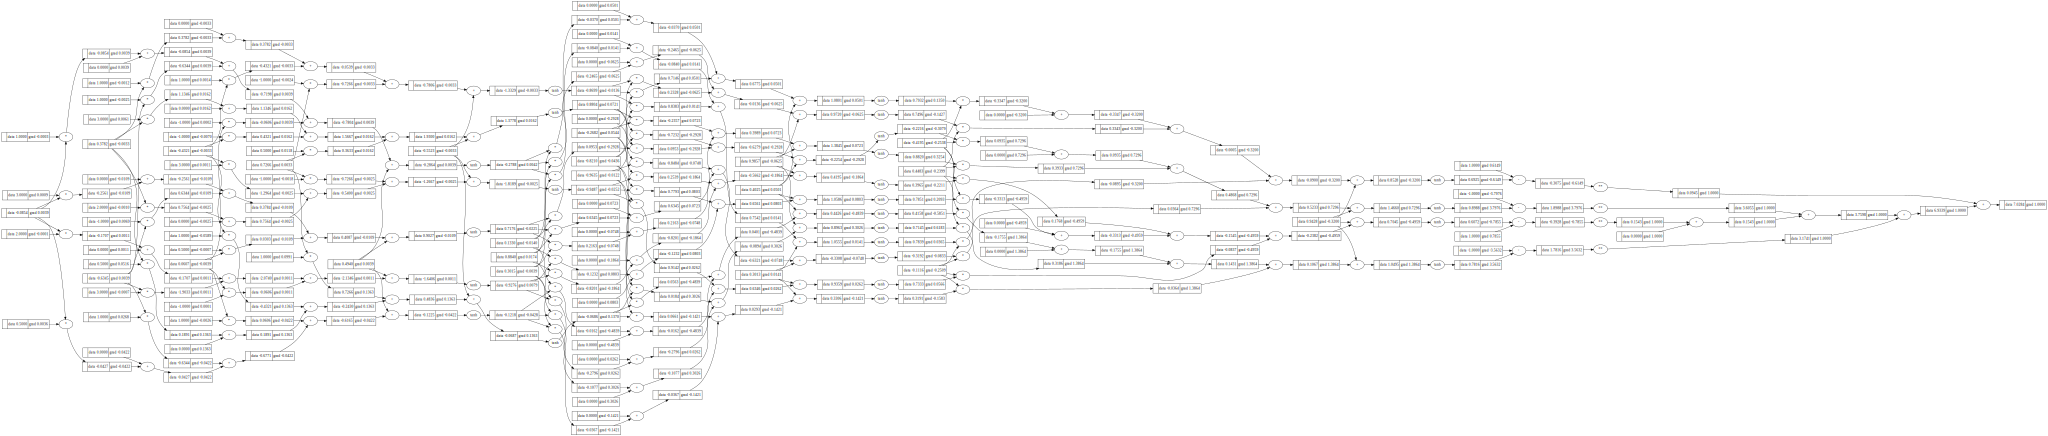

In [ ]:
n_epochs = 100

input_size = 3 # Number of features in the input layer
layer_sizes = [2, 3, 1] # Number of neurons in each hidden and output layer
model = MLP(input_size, layer_sizes)

optim = Optimizer(model.parameters(), lr=0.01)

for i in range(n_epochs):
  # Forward pass: Compute predictions for the entire dataset
  y_hats = [model(x) for x in X]

  # Compute the loss
  loss = criterion(y_hats, Y)
  print(f'iteration: {i}, loss: {loss}')

  # Zero the gradients to prevent accumulation from previous iterations
  optim.zero_grad()

  # Backward pass: Compute the gradient of the loss function with respect to model parameters
  loss.backward()
  # print(f'iteration: {i}, loss: {loss}')

  # Update the model parameters using the optimizer
  optim.step()

draw_dot(loss)